In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT,
    RegressionEnsembleModel,
    StandardRegressionModel,
    EnsembleModel,
)
from darts.metrics import mape, mase, rmse, r2_score, mae, marre, mse
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
# read from saved csv file
df = pd.read_csv('df_order.csv')
df = df.rename(columns={'order_id': 'order_quantity'})
df 

,date,order_quantity,total,quantity
0,2014-05-13,3,125.65,12
1,2014-05-14,3,233.39,17
2,2014-05-26,1,90.96,3
3,2014-05-31,1,381.13,13
4,2014-06-01,1,229.40,12
...,...,...,...,...
1071,2021-01-31,5,8183.72,162
1072,2021-02-01,22,28697.62,318
1073,2021-02-02,31,39878.66,872
1074,2021-02-03,32,19812.30,405


In [3]:
# reorganize the dataset select 
df_order_quantity = df[['date', 'order_quantity']]
df_order_quantity = df_order_quantity.set_index('date') 
df_order_quantity.index = pd.to_datetime(df_order_quantity.index) 
y = df_order_quantity['order_quantity'].resample('D').sum()
y = y.fillna(value=0)
df_all = pd.DataFrame(y) 
df_all = df_all[1694:]
df_all 

,order_quantity
date,
2019-01-01,0
2019-01-02,1
2019-01-03,0
2019-01-04,1
2019-01-05,0
...,...
2021-01-31,5
2021-02-01,22
2021-02-02,31


In [4]:
df = df_all.copy() 
df = df.reset_index()  

In [5]:
from statsmodels.tsa.stattools import adfuller
series = df['order_quantity']  
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.655372
p-value: 0.082084
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [6]:
series = df['order_quantity']   
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.655372
p-value: 0.082084
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


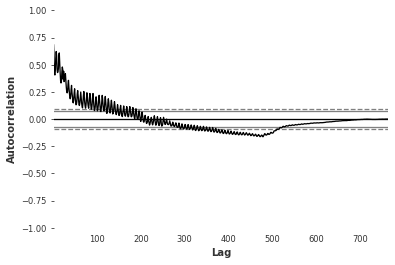

In [7]:
pd.plotting.autocorrelation_plot(df['order_quantity'].iloc[1:]);  

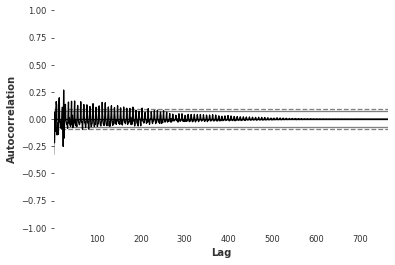

In [8]:
pd.plotting.autocorrelation_plot(df['order_quantity'].diff(1).iloc[1:]);  


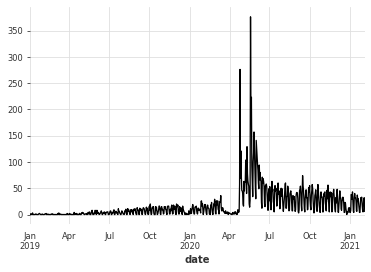

In [9]:
#df = df_all[56:].copy() 
#df = df.reset_index()  
series = TimeSeries.from_dataframe(df, 'date', ['order_quantity'])
series.plot()

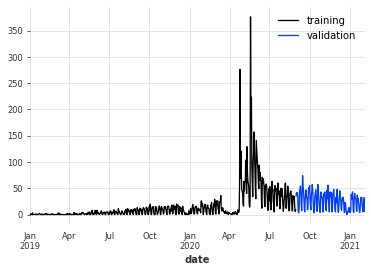

In [10]:
train, val = series.split_before(pd.Timestamp('2020-08-31'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

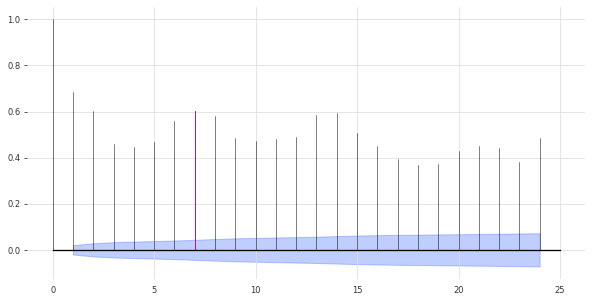

In [11]:
plot_acf(train, m = 7, alpha = .05)

In [12]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


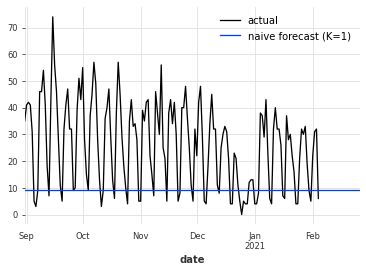

In [13]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(180)

val.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

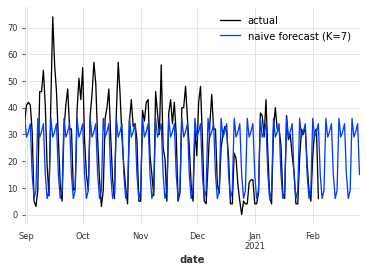

In [14]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(180)

val.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=7)')
plt.legend();

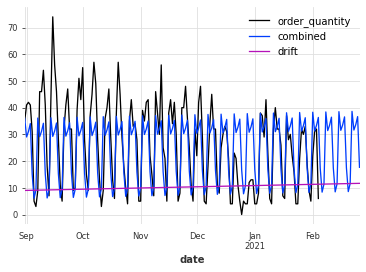

In [15]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(180)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

val.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();

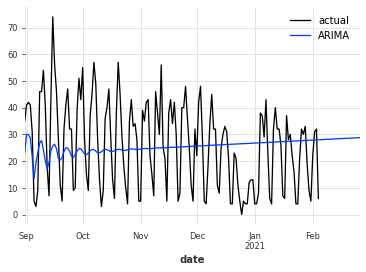

In [16]:
arima_model = ARIMA()
arima_model.fit(train)
arima_forecast = arima_model.predict(180)

val.plot(label='actual')
arima_forecast.plot(label='ARIMA')
plt.legend(); 

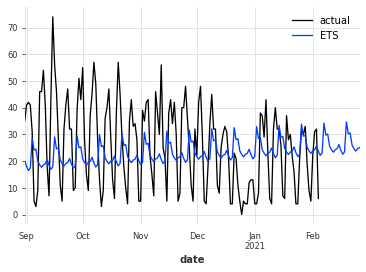

In [17]:
ets_model = ExponentialSmoothing()
ets_model.fit(train)
ets_forecast = ets_model.predict(180)

val.plot(label = 'actual') 
ets_forecast.plot(label='ETS')
plt.legend(); 

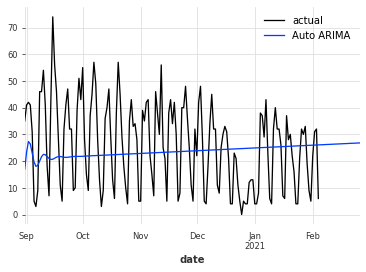

In [18]:
autoarima_model = AutoARIMA()
autoarima_model.fit(train)
autoarima_forecast = autoarima_model.predict(180)

val.plot(label = 'actual') 
autoarima_forecast.plot(label='Auto ARIMA')
plt.legend(); 

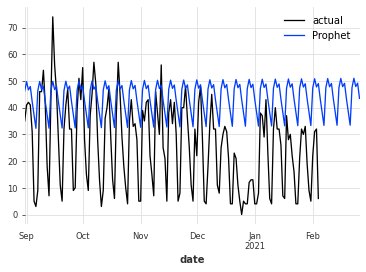

In [19]:
pr_model = Prophet()
pr_model.fit(train)
pr_forecast = pr_model.predict(180)

val.plot(label='actual')
pr_forecast.plot(label='Prophet')
plt.legend();

In [20]:
print("Root mean squared error for the combined naive drift + seasonal: {:.2f}%.".format(
      rmse(series, combined_forecast)))

Root mean squared error for the combined naive drift + seasonal: 11.96%.


In [21]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains RMSE: {:.2f}'.format(model, rmse(val, forecast)))
    
eval_model(NaiveSeasonal(K=7))
#eval_model(NaiveDrift()) 
eval_model(ARIMA())
#eval_model(AutoARIMA())
eval_model(ExponentialSmoothing())
eval_model(Prophet())
#eval_model(StandardRegressionModel())
#eval_model(RegressionEnsembleModel())


model Naive seasonal model, with K=7 obtains RMSE: 11.89
model ARIMA(12,1,0) obtains RMSE: 16.09
model Exponential smoothing obtains RMSE: 17.32
model Prophet obtains RMSE: 21.59


In [22]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAE : {:.2f}'.format(model, mae(val, forecast)))
    
eval_model(NaiveSeasonal(K=7))
#eval_model(NaiveDrift()) 
eval_model(ARIMA())
#eval_model(AutoARIMA())
eval_model(ExponentialSmoothing())
eval_model(Prophet())
#eval_model(StandardRegressionModel())
#eval_model(RegressionEnsembleModel())


model Naive seasonal model, with K=7 obtains MAE : 8.87
model ARIMA(12,1,0) obtains MAE : 13.87
model Exponential smoothing obtains MAE : 14.73
model Prophet obtains MAE : 18.67


In [23]:
models = [NaiveSeasonal(6), NaiveSeasonal(12), NaiveDrift()]

model_predictions = [m.historical_forecasts(series, start=pd.Timestamp('2020-05-31'), forecast_horizon=6, verbose=True)
                     for m in models]

In [24]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

In [25]:
df = pd.read_csv('df_order.csv')
train, val = series.split_before(pd.Timestamp('2020-08-31'))
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [26]:
my_model_RNN = RNNModel(
    model='RNN',
    input_chunk_length=14,
    output_chunk_length=7,
    hidden_size=25,
    n_rnn_layers=1,
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='so-RNN',
    log_tensorboard=True,
    random_state=42
)

In [27]:
my_model_RNN.fit(train_transformed, val_series=val_transformed, verbose=True)  # 107

Training loss: 0.0017, validation loss: 0.0010, best val loss: 0.0007


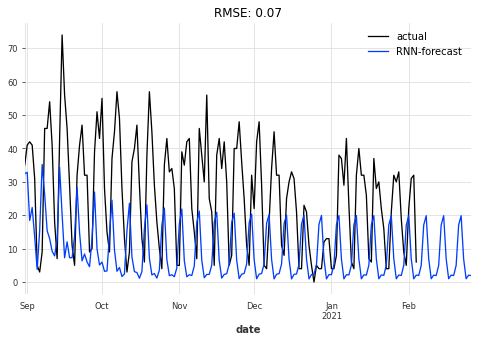

In [28]:
RNN_pred = my_model_RNN.predict(n=180)
RNN_pred_inverse = transformer.inverse_transform(RNN_pred)
plt.figure(figsize=(8,5))
val.plot(label='actual')
RNN_pred_inverse.plot(label='RNN-forecast')
plt.title('RMSE: {:.2f}'.format(rmse(RNN_pred, val_transformed)))
plt.legend(); 

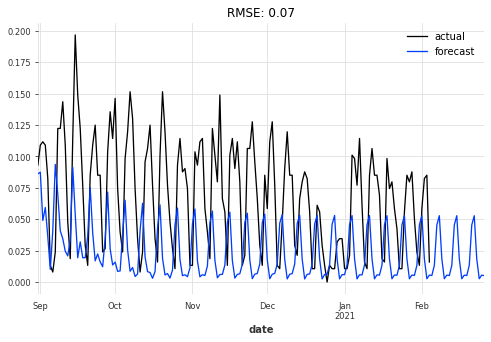

In [29]:
def eval_model(model):
    pred_series = model.predict(n=180)
    plt.figure(figsize=(8,5))
    val_transformed.plot(label='actual') 
    pred_series.plot(label='forecast')
    plt.title('RMSE: {:.2f}'.format(rmse(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model_RNN)

loading model_best_110.pth.tar


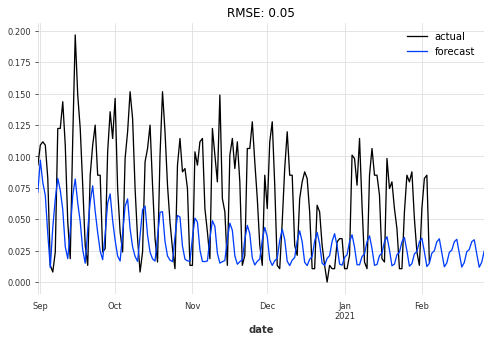

In [30]:
best_model_RNN = RNNModel.load_from_checkpoint(model_name='so-RNN', best=True)
eval_model(best_model_RNN)

In [31]:
backtest_series = my_model_RNN.historical_forecasts(series_transformed,
                                                start=pd.Timestamp('2020-07-31'),
                                                forecast_horizon=60,
                                                retrain=False,
                                                verbose=True)

RMSE: 27.24


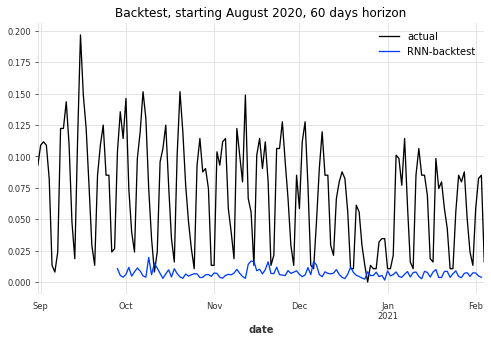

In [32]:

plt.figure(figsize=(8,5))
val_transformed.plot(label='actual')
backtest_series.plot(label='RNN-backtest') 
plt.legend()
plt.title('Backtest, starting August 2020, 60 days horizon');
print('RMSE: {:.2f}'.format(rmse(transformer.inverse_transform(val_transformed),  
                                  transformer.inverse_transform(backtest_series))))

In [33]:
my_model_gru = RNNModel(
    model='GRU',
    input_chunk_length=14,
    output_chunk_length=7,
    hidden_size=25,
    n_rnn_layers=1,
    batch_size=64,
    n_epochs=1500,
    dropout=0.2,
    model_name='so_GRU',
    log_tensorboard=True,
    random_state=42
)

In [34]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.0013, validation loss: 0.0007, best val loss: 0.0007


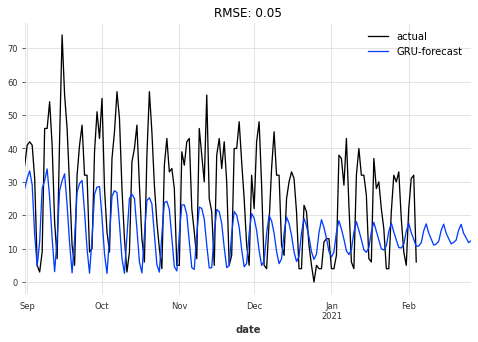

In [35]:
GRU_pred = my_model_gru.predict(n=180)
GRU_pred_inverse = transformer.inverse_transform(GRU_pred)
plt.figure(figsize=(8,5))
val.plot(label='actual')
GRU_pred_inverse.plot(label='GRU-forecast')
plt.title('RMSE: {:.2f}'.format(rmse(GRU_pred, val_transformed))) 
plt.legend(); 

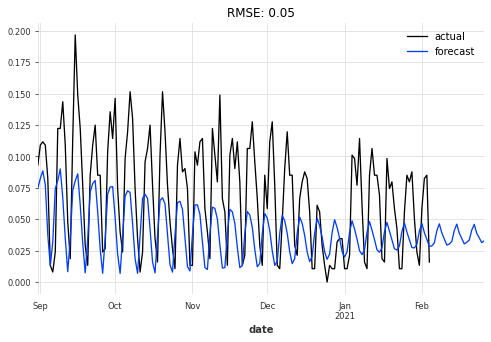

In [36]:
eval_model(my_model_gru)

loading model_best_1400.pth.tar


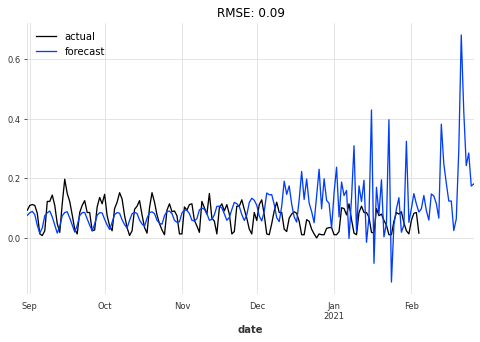

In [37]:
best_model_gru = RNNModel.load_from_checkpoint(model_name='so_GRU', best=True)
eval_model(best_model_gru)

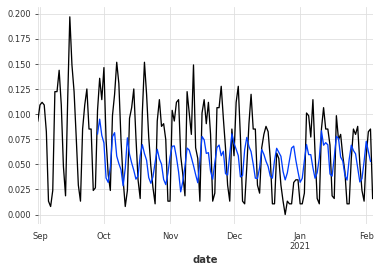

In [38]:
backtest_series = my_model_gru.historical_forecasts(series_transformed,
                                                    start=pd.Timestamp('2020-07-31'),
                                                    forecast_horizon=60,
                                                    retrain=False,
                                                    verbose=True)
val_transformed.plot(label='actual') 
backtest_series.plot(label='GRU-backtest')

In [39]:
my_model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=14,
    output_chunk_length=7,
    hidden_size=25,
    n_rnn_layers=1,
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='so-LSTM',
    log_tensorboard=True,
    random_state=42
)

In [40]:
my_model_lstm.fit(train_transformed, val_series=val_transformed, verbose=True)  # 107

Training loss: 0.0017, validation loss: 0.0008, best val loss: 0.0008


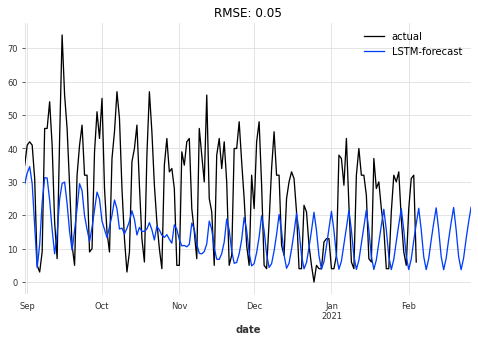

In [41]:
LSTM_pred = my_model_lstm.predict(n=180)
LSTM_pred_inverse = transformer.inverse_transform(LSTM_pred)
plt.figure(figsize=(8,5))
val.plot(label='actual')
LSTM_pred_inverse.plot(label='LSTM-forecast')
plt.title('RMSE: {:.2f}'.format(rmse(LSTM_pred, val_transformed))) 
plt.legend();  

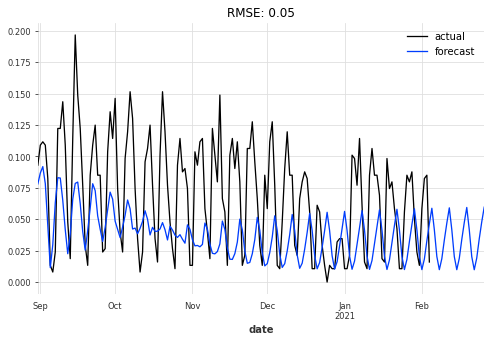

In [42]:
eval_model(my_model_lstm)

loading model_best_350.pth.tar


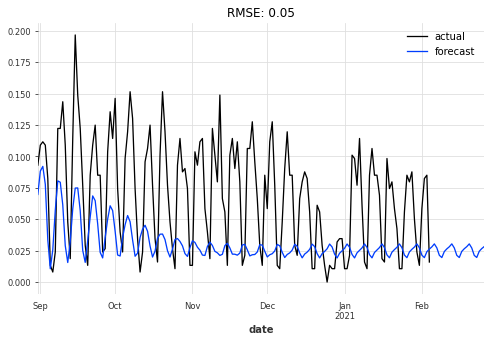

In [43]:
best_model = RNNModel.load_from_checkpoint(model_name='so-LSTM', best=True)
eval_model(best_model)

In [44]:
backtest_series = my_model_lstm.historical_forecasts(series_transformed,
                                                start=pd.Timestamp('2020-07-31'),
                                                forecast_horizon=60,
                                                retrain=False,
                                                verbose=True)

MRSE: 12.70


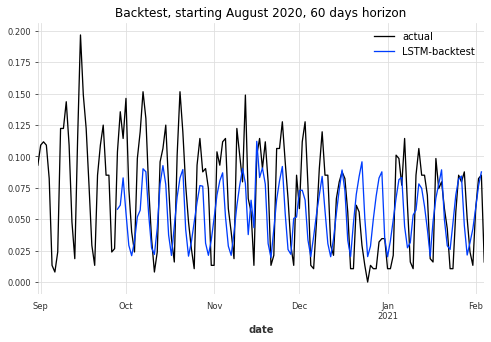

In [45]:

plt.figure(figsize=(8,5))
val_transformed.plot(label='actual')
backtest_series.plot(label='LSTM-backtest')
plt.legend()
plt.title('Backtest, starting August 2020, 60 days horizon');
print('MRSE: {:.2f}'.format(rmse(transformer.inverse_transform(val_transformed), 
                                  transformer.inverse_transform(backtest_series))))

In [46]:
from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values

In [47]:
model_TCN = TCNModel(
    input_chunk_length=14,
    output_chunk_length=7, 
    n_epochs=400, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [48]:
model_TCN.fit(series=train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.0030, validation loss: 0.0011, best val loss: 0.0011


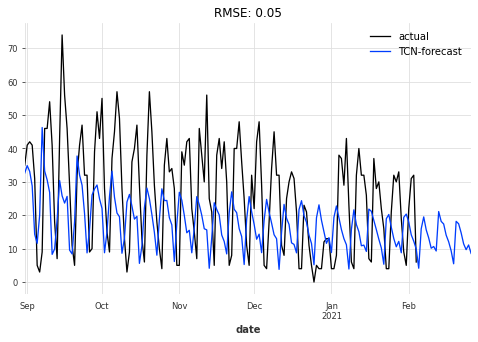

In [49]:
TCN_pred = model_TCN.predict(n=180)
TCN_pred_inverse = transformer.inverse_transform(TCN_pred)
plt.figure(figsize=(8,5))
val.plot(label='actual')
TCN_pred_inverse.plot(label='TCN-forecast')
plt.title('RMSE: {:.2f}'.format(rmse(TCN_pred, val_transformed))) 
plt.legend();  

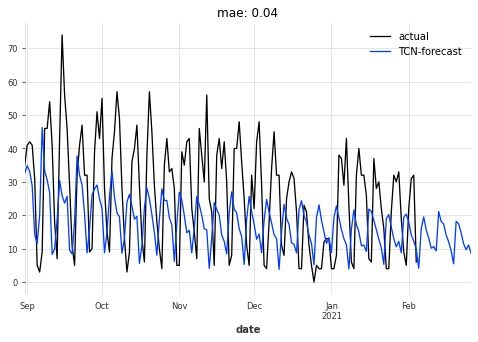

In [50]:
TCN_pred = model_TCN.predict(n=180)
TCN_pred_inverse = transformer.inverse_transform(TCN_pred)
plt.figure(figsize=(8,5))
val.plot(label='actual')
TCN_pred_inverse.plot(label='TCN-forecast')
plt.title('mae: {:.2f}'.format(mae(TCN_pred, val_transformed))) 
plt.legend();  

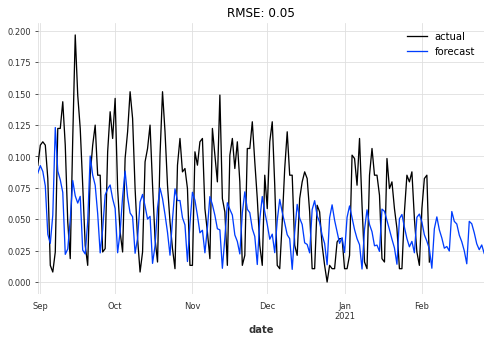

In [51]:
eval_model(model_TCN)

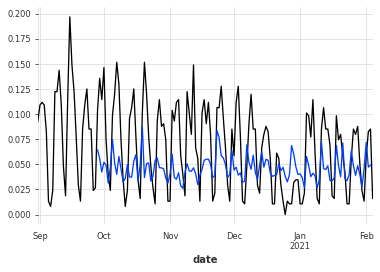

In [52]:
backtest_series = model_TCN.historical_forecasts(series_transformed,
                                                start=pd.Timestamp('2020-07-31'),
                                                forecast_horizon=60,
                                                retrain=False,
                                                verbose=True)

val_transformed.plot(label='actual') 
backtest_series.plot(label='LSTM-backtest')

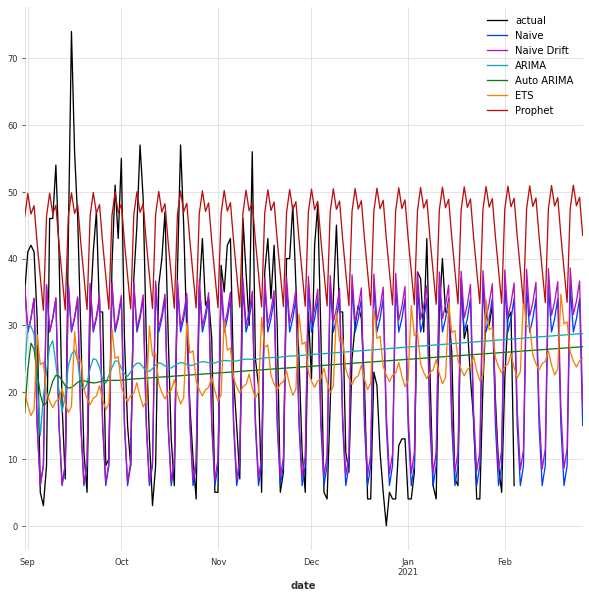

In [53]:
plt.figure(figsize=(10,10))
val.plot(label = 'actual') 
seasonal_forecast.plot(label = 'Naive')
combined_forecast.plot(label = 'Naive Drift')
arima_forecast.plot(label = 'ARIMA')
autoarima_forecast.plot(label = 'Auto ARIMA')
ets_forecast.plot(label='ETS')
pr_forecast.plot(label='Prophet')
#RNN_pred_inverse.plot(label='RNN')
#GRU_pred_inverse.plot(label='GRU')
#LSTM_pred_inverse.plot(label='LSTM')
#TCN_pred_inverse.plot(label='TCN')
plt.legend(); 

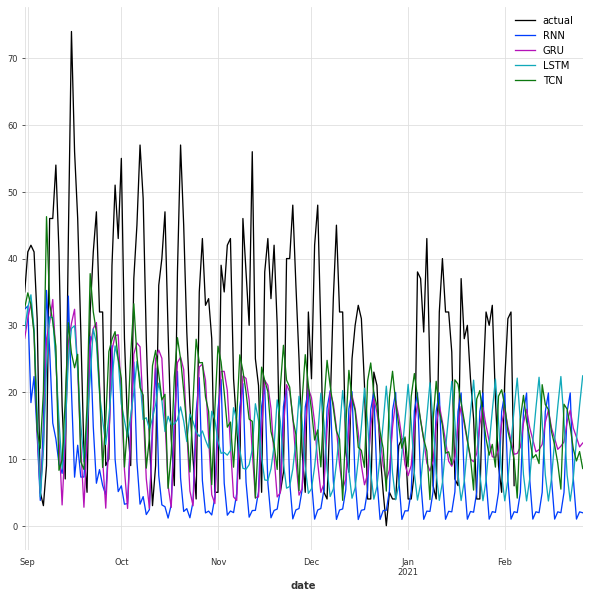

In [54]:
plt.figure(figsize=(10,10))
val.plot(label = 'actual') 
RNN_pred_inverse.plot(label='RNN')
GRU_pred_inverse.plot(label='GRU')
LSTM_pred_inverse.plot(label='LSTM')
TCN_pred_inverse.plot(label='TCN')
plt.legend(); 

In [55]:
df_aws = pd.read_csv('sowingo_orderq_forecast_Feb1_7_2021-04-04T01-13-38Z_part0.csv')
df_aws 

,item_id,date,p10,p50,p90,mean,Actual data,Unnamed: 7
0,order_quantity,2021-02-01,25.36,37.85,52.28,37.46,22.0,NaN
1,order_quantity,2021-02-02,22.29,36.16,46.26,36.52,31.0,NaN
2,order_quantity,2021-02-03,24.84,37.21,47.38,36.76,32.0,NaN
3,order_quantity,2021-02-04,21.79,36.28,46.75,35.14,6.0,NaN
4,order_quantity,2021-02-05,21.64,32.71,46.02,33.08,NaN,NaN
5,order_quantity,2021-02-06,5.26,9.49,20.41,10.07,NaN,NaN
6,order_quantity,2021-02-07,4.97,9.72,17.13,10.50,NaN,NaN


In [56]:
df_aws = df_aws.drop(columns={'item_id', 'Unnamed: 7'})
df_aws 

,date,p10,p50,p90,mean,Actual data
0,2021-02-01,25.36,37.85,52.28,37.46,22.0
1,2021-02-02,22.29,36.16,46.26,36.52,31.0
2,2021-02-03,24.84,37.21,47.38,36.76,32.0
3,2021-02-04,21.79,36.28,46.75,35.14,6.0
4,2021-02-05,21.64,32.71,46.02,33.08,NaN
5,2021-02-06,5.26,9.49,20.41,10.07,NaN
6,2021-02-07,4.97,9.72,17.13,10.50,NaN


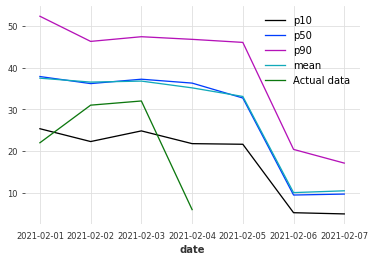

In [57]:
df_aws.plot(x='date'); 

In [58]:
df 

,date,order_id,total,quantity
0,2014-05-13,3,125.65,12
1,2014-05-14,3,233.39,17
2,2014-05-26,1,90.96,3
3,2014-05-31,1,381.13,13
4,2014-06-01,1,229.40,12
...,...,...,...,...
1071,2021-01-31,5,8183.72,162
1072,2021-02-01,22,28697.62,318
1073,2021-02-02,31,39878.66,872
1074,2021-02-03,32,19812.30,405


In [59]:
df_all 

,order_quantity
date,
2019-01-01,0
2019-01-02,1
2019-01-03,0
2019-01-04,1
2019-01-05,0
...,...
2021-01-31,5
2021-02-01,22
2021-02-02,31


In [60]:
df_all['days since'] = df_all.index-df_all.index[0]
df_all['days since'] = df_all['days since'].dt.days
train_data = df_all.iloc[:int(df_all.shape[0]*0.80)]
test_data = df_all.iloc[int(df_all.shape[0]*0.80):] 

In [61]:
train_data

,order_quantity,days since
date,,
2019-01-01,0,0
2019-01-02,1,1
2019-01-03,0,2
2019-01-04,1,3
2019-01-05,0,4
...,...,...
2020-08-30,9,607
2020-08-31,35,608
2020-09-01,41,609


In [62]:
test_data

,order_quantity,days since
date,,
2020-09-04,31,612
2020-09-05,5,613
2020-09-06,3,614
2020-09-07,9,615
2020-09-08,46,616
...,...,...
2021-01-31,5,761
2021-02-01,22,762
2021-02-02,31,763


In [63]:
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [64]:
# build svm
kernel = ['rbf']
C = [0.01]
gamma = [0.01, 0.1]
epsilon = [0.1]
shrinking = [True, False]
svm_grid = {'kernel':kernel,'C':C,'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}
SVM = SVR()
svm_search = RandomizedSearchCV(SVM,svm_grid,cv=3) 
svm_search.fit(np.array(train_data['days since']).reshape(-1,1),np.array(train_data['order_quantity']).reshape(-1,1))

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': [0.01], 'epsilon': [0.1],
                                        'gamma': [0.01, 0.1], 'kernel': ['rbf'],
                                        'shrinking': [True, False]})

In [65]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.1, 'C': 0.01}

In [66]:
svm_confirmed = svm_search.best_estimator_
svm_confirmed

SVR(C=0.01, gamma=0.01)

In [67]:
prediction_SVM = svm_confirmed.predict(np.array(test_data['days since']).reshape(-1,1))
rmse_SVM = np.sqrt(mean_squared_error(np.array(test_data['order_quantity']).reshape(-1,1),prediction_SVM))
print(rmse_SVM)
print('Percentage accuracy for support vector regression model: ',(1-np.mean(np.abs((np.array(test_data['order_quantity']).reshape(-1,1)-prediction_SVM)/np.array(test_data['order_quantity']).reshape(-1,1))))*100,'%')

26.19933436914734
Percentage accuracy for support vector regression model:  -inf %


In [68]:

#Building the random forest model
RF_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [4],
    'min_samples_split': [2, 5],
    'n_estimators': [500]
}

RF = RandomForestRegressor()
RF_search = RandomizedSearchCV(RF,RF_grid,cv=3)
RF_search.fit(np.array(train_data['days since']).reshape(-1,1),np.array(train_data['order_quantity']).reshape(-1,1))

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [500]})

In [69]:
RF_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [70]:
RF_confirmed = RF_search.best_estimator_
RF_confirmed

RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=500)

In [71]:
prediction_RF = RF_confirmed.predict(np.array(test_data['days since']).reshape(-1,1))
rmse_RF = np.sqrt(mean_squared_error(np.array(test_data['order_quantity']).reshape(-1,1),prediction_RF))
print(rmse_RF)
print('Percentage accuracy for Random Forest regression model: ',(1-np.mean(np.abs((np.array(test_data['order_quantity']).reshape(-1,1)-prediction_RF)/np.array(test_data['order_quantity']).reshape(-1,1))))*100,'%')

16.484859995676572
Percentage accuracy for Random Forest regression model:  -inf %


In [72]:
#Building the gradient boost model
GB_grid = {
    'n_estimators':[500], 
    'learning_rate': [0.1,0.01],
    'max_depth':[4], 
    'min_samples_leaf':[3], 
    'max_features':[1.0]
}
GB = GradientBoostingRegressor()
GB_search = RandomizedSearchCV(GB,GB_grid,cv=3)
GB_search.fit(np.array(train_data['days since']).reshape(-1,1),np.array(train_data['order_quantity']).reshape(-1,1))

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [4], 'max_features': [1.0],
                                        'min_samples_leaf': [3],
                                        'n_estimators': [500]})

In [73]:
GB_search.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 3,
 'max_features': 1.0,
 'max_depth': 4,
 'learning_rate': 0.1}

In [74]:
GB_confirmed = GB_search.best_estimator_
GB_confirmed

GradientBoostingRegressor(max_depth=4, max_features=1.0, min_samples_leaf=3,
                          n_estimators=500)

In [75]:

prediction_GB = GB_confirmed.predict(np.array(test_data['days since']).reshape(-1,1))
rmse_GB = np.sqrt(mean_squared_error(np.array(test_data['order_quantity']).reshape(-1,1),prediction_GB))
print(rmse_GB)
print('Percentage accuracy for Gradient Boost regression model: ',(1-np.mean(np.abs((np.array(test_data['order_quantity']).reshape(-1,1)-prediction_GB)/np.array(test_data['order_quantity']).reshape(-1,1))))*100,'%')

22.5038924392474
Percentage accuracy for Gradient Boost regression model:  -inf %


In [76]:

#predict for next 10 days using these 3 models

new_date = []
new_prediction_SVM = []
new_prediction_RF = []
new_prediction_GB = []
for i in range(1,10):
    new_date.append(df_all.index[-1]+timedelta(days=i))
    new_prediction_SVM.append(svm_confirmed.predict(np.array(df_all['days since'].max()+i).reshape(-1,1))[0])
    new_prediction_RF.append(RF_confirmed.predict(np.array(df_all['days since'].max()+i).reshape(-1,1))[0])
    new_prediction_GB.append(GB_confirmed.predict(np.array(df_all['days since'].max()+i).reshape(-1,1))[0])
pd.set_option('display.float_format',lambda x: '%.f'%x)
model_predictions = pd.DataFrame(zip(new_date,new_prediction_SVM,new_prediction_RF,new_prediction_GB),columns=['Dates','SVR','RF','GB'])
model_predictions.head(10)

,Dates,SVR,RF,GB
0,2021-02-05,5,29,42
1,2021-02-06,5,29,42
2,2021-02-07,5,29,42
3,2021-02-08,5,29,42
4,2021-02-09,5,29,42
5,2021-02-10,5,29,42
6,2021-02-11,5,29,42
7,2021-02-12,5,29,42
8,2021-02-13,5,29,42
